In [2]:
#% matplotlib inline

from datetime import datetime 
import h5py
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
cmap = cm.get_cmap('Blues')
import random
from numpy.linalg import lstsq
import scipy.stats as stats

# sys.path.append('/gpfs01/euler/User/avlasits/PythonCode/amacrine-analysis')
# from AnalysisPack import * 

# target_user = 'Vlasits'

# restriction_str = 'experimenter = "{}"'.format(target_user)

In [3]:
# For plotting, from Luke

def compute_bounds(mu, sig, n_sigma = 3):
    """
    Use mean and standard deviation vectors to compute upper and lower bounds.
    """
    upper = mu + n_sigma * np.sqrt(np.abs(sig))
    lower = mu - n_sigma * np.sqrt(np.abs(sig))
    
    return upper, lower

In [7]:
#read hdf5 file for this notebook
f1 = h5py.File("Data/FigS02.hdf5", "r")

#get the data for plotting the sd image
dataCh0 = np.array(f1['dataCh0'])
roimask = np.array(f1['roimask'])
x_zoom = np.array(f1['x_zoom'])
z_zoom = np.array(f1['z_zoom'])
iplmask = np.array(f1['iplmask'])
ipl_pixels = np.array(f1['ipl_pixels'])
left = np.array(f1['left'])
right = np.array(f1['right'])
thick = np.array(f1['thick'])


f1.close()

# Plot the sd image for this field

In [8]:
std = np.std(dataCh0, axis=2)  # standard deviation across time

#scaling
um_pixel_z = (61.6/std.shape[1])/z_zoom
um_pixel_x = (71.5/std.shape[0])/x_zoom

aspect = ((71.5/std.shape[0])/x_zoom)/((61.6/std.shape[1])/z_zoom)

In [9]:
#scale bar
scale_bar_length = 20
pixels = std.shape[0]

total_length = pixels * um_pixel_x
start = 0.8
stop = (start*total_length+scale_bar_length)/total_length

total_length_z = std.shape[1] * um_pixel_z

(10, 54)

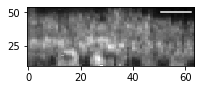

In [10]:
fig = plt.figure(figsize=(3,3))

top_bound = 50
bottom_bound = 15

plt.imshow(std.T[:,:], cmap='Greys_r', origin='lower', aspect=1/aspect)
# plt.axhline(top_bound)
# plt.axhline(bottom_bound)
axes=plt.gca()
# axes.set_ylim([bottom_bound, top_bound])

plt.axhline(50,start,stop,  color='white')

axes.set_ylim([10,54])

# Figpath = 'Fig_temp/'
# savename = Figpath+"XZ_example_std.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

# Get Snippets Information

In [13]:
#pull this data from the hdf5 file
data_df = pd.read_hdf('Data/FigS02.hdf5', 'snippet_data_df')

# Get model responses from GP (Bct)

In [17]:
#pull this data from the hdf5 file
results = pd.read_hdf('Data/FigS02.hdf5', 'gp_results_df')
results_ds = pd.read_hdf('Data/FigS02.hdf5', 'dprime_results_df')

In [18]:
#select a specific ROI to plot
center_px_id = 110  #ROIs used in Figure: #for DS pixel: 110, 402; for non-DS: 698, 800
color_id = 6
results_roi = results.loc[results['center_pixel_id']==center_px_id]
results_ds_roi = results_ds.loc[results_ds['center_pixel_id']==center_px_id]

In [20]:
#pull out the relevant data
mu = results_roi['mu'].values[0]
x_predict = results_roi['x_predict'].values[0]
sig = results_roi['sig'].values[0]
sig_outer = results_roi['sig_outer'].values[0]
x_predict_t = np.copy(x_predict[::mu.shape[0],:])

#get SD of responses for normalization
rois = results_roi['roi_list'].values[0]

#get the average response of these rois (averaged over binned time of the traces) that was used for GP modeling
df_GP_rois = data_df.loc[rois].groupby(
    ['directions', 'lengths', 'trial_nums', 'time_resampled']).mean()

df_GP_rois = df_GP_rois.reset_index()
df_GP_rois = df_GP_rois.set_index(['directions', 'lengths', 'time_bin'])

df_GP_rois_average = df_GP_rois.groupby(['directions', 'lengths', 'time_bin']).mean()

mean_of_trace = df_GP_rois['y'].mean()
sd_of_trace = df_GP_rois['y'].std()

#normalize GP predictions for plotting
mu1 = results_ds_roi['mu1'].values[0]
mu2 = results_ds_roi['mu2'].values[0]

mu1_norm = mu1/sd_of_trace
mu2_norm = mu2/sd_of_trace

<Figure size 1080x432 with 0 Axes>

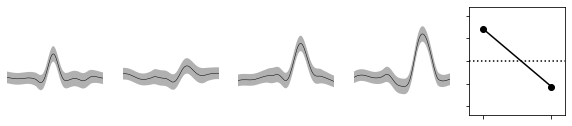

In [22]:
plt.figure(figsize=(15, 6))
directions = [0, 180]
lengths = [150, 300]

colors1 = ['peru', 'lightseagreen', 'peru', 'lightseagreen', 'peru', 'lightseagreen']
colors2 = ['blue', 'black', 'green', 'magenta', 'purple', 'orange']
# colors3 = cm.get_cmap('Dark2')

n_conditions = mu.shape[0]
gp_index = [0, 2, 1, 3, 5, 4]
gp_index = [3, 0, 5, 2, 4, 1]
gp_index = [1, 3, 0, 2]
color_id = 6

plt.figure(figsize=(10, 2))

index = 1
for length in lengths:
    for direction in directions:

        ax1 = plt.subplot(1,5,index)
        upper, lower = compute_bounds(mu[gp_index[index-1],:]/sd_of_trace, sig[gp_index[index-1],:]/sd_of_trace, n_sigma = 3, )
        plt.fill_between(x_predict_t[:,0], upper, lower, facecolor = 'k', alpha = 0.3, )
        plt.plot(x_predict_t[:,0], mu[gp_index[index-1],:]/sd_of_trace, color='k', label=str(direction)+', '+str(length), lw=0.5)
        
        plt.axis('off')
        axes = plt.gca()
        axes.set_xlim([0.5, 2.])
        axes.set_ylim([-2, 3.5])
        index+=1

ax1 = plt.subplot(1,5,5)    
lengths = ['150', '300']

plt.plot(lengths, results_ds_roi['d_prime'].values[0], color='k', marker='o')

axes = plt.gca()
axes.set_ylim([-60,60])
axes.set_xlim([-0.2,1.2])
axes.axhline(linestyle='dotted', color='k')
# Turn off tick labels
axes.set_yticklabels([])
axes.set_xticklabels([])

# Figpath = 'Fig_temp/'
# savename = Figpath+"X_xz_gp_example_"+str(pixel_ex)+".pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')
        
plt.show()

# plotting a map of d' for this xz field

In [29]:
dsi_results = results_ds.drop(columns=['experimenter', 'date', 'exp_num', 'field_id', 'stim_id', 'presentation_id','preprocess_param_set_id', 'resample_f_id', 'gp_bct_id','mu1',
                                     'mu2','sig1','sig2','mu_max_index'])
dsi_results = dsi_results.rename(columns={"center_pixel_id": "pixel_id"})
dsi_results = dsi_results.set_index('pixel_id')


In [30]:
#remove non-responsive pixels, where the model failed to detect a large change in response
threshold = 0.05
dsi_results = dsi_results[dsi_results['mu_std_max']>threshold]
dsi_results.pop('mu_std_max')

dsi_results['dsi_150'] = dsi_results['d_prime'].apply(lambda x: x[0])
dsi_results['dsi_300'] = dsi_results['d_prime'].apply(lambda x: x[1])

In [32]:
ipl_rois_analyzed = list(set(ipl_pixels).intersection(list(dsi_results.index.to_frame()['pixel_id'])))

dsi_results = dsi_results.loc[ipl_rois_analyzed]

In [33]:
std_150 = dsi_results['dsi_150'].std()
std_300 = dsi_results['dsi_300'].std()

mean_dsi = dsi_results['d_prime'].mean()

std_dsi = np.array([std_150, std_300])

std_top = mean_dsi + std_dsi
std_bottom = mean_dsi - std_dsi

In [36]:
dsi_results['dsi_150'].max(), dsi_results['dsi_300'].max()

(51.29149501404296, 52.9152291706793)

In [37]:
dsi_results['dsi_150'].min(), dsi_results['dsi_300'].min()

(-44.08033179645053, -51.855798556542744)

In [38]:
cm = plt.get_cmap('BrBG_r') #sns.diverging_palette(20, 220, n=50)
cm.set_bad(color='lightgrey')
color_range = 40

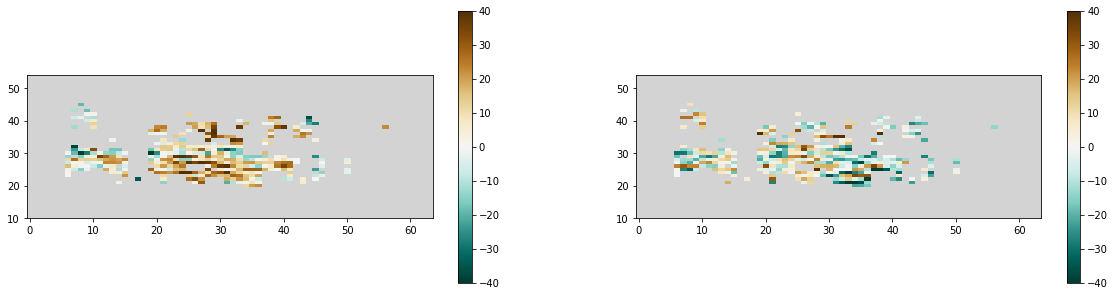

In [39]:
roi_list = dsi_results.index.to_frame(index=False)['pixel_id'].unique()

#make map for 150 length stimulus
dsmap1 = iplmask*(-1)
xlength = dsmap1.shape[0]
ylength = dsmap1.shape[1]
for x in range(xlength):
    for y in range(ylength):  
        if dsmap1[x,y] in roi_list:
            roi_index = np.int(dsmap1[x, y])
            dsmap1[x,y] = dsi_results.loc[roi_index, 'dsi_150']
        else:
            dsmap1[x,y] = np.nan

            
#make map for 300 length stimulus            
dsmap2 = iplmask*(-1)
xlength = dsmap2.shape[0]
ylength = dsmap2.shape[1]
for x in range(xlength):
    for y in range(ylength):  
        if dsmap2[x,y] in roi_list:
            roi_index = np.int(dsmap2[x, y])
            dsmap2[x,y] = dsi_results.loc[roi_index, 'dsi_300']
        else:
            dsmap2[x,y] = np.nan

                  
fig = plt.figure(figsize=(20, 5))

ax1 = fig.add_subplot(1,2,1)
plt.imshow(dsmap1.T, cmap=cm, vmin=-1*color_range, vmax=color_range, aspect=1/aspect, origin='lower') #'RdYlBu'
cb = plt.colorbar()
ax1.set_ylim([10,54])



ax2 = fig.add_subplot(1,2,2)
plt.imshow(dsmap2.T, cmap=cm, vmin=-1*color_range, vmax=color_range, aspect=1/aspect, origin='lower') #'RdYlBu'
cb = plt.colorbar()
ax2.set_ylim([10,54])

#cb.remove()
plt.draw()


# if plotsave == True:
#     savename = Figpath+"DS_map_ds_rois300_lengths300.pdf"
#     plt.savefig(savename, transparent=True, bbox_inches='tight')

# Figpath = 'Fig_temp/'
# savename = Figpath+"Xz_dsi_maps.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()

(-0.15, 1.15)

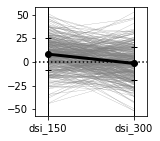

In [41]:
from pandas.plotting import parallel_coordinates

toplot = dsi_results.reset_index()
plt.figure(figsize = (2,2))




ax = plt.subplot(1,1,1)
parallel_coordinates(toplot, 'pixel_id', cols=['dsi_150', 'dsi_300'], color = 'grey', linewidth=0.2)#colormap='Greys',linestyle='dotted', marker = '.',

# parallel_coordinates(toplot, 'pixel_id', cols=['dsi_150', 'dsi_300'], color = 'black', linewidth=0.2)#colormap='Greys',linestyle='dotted', marker = '.',


plt.plot(mean_dsi, color='k', linewidth=3, marker='o')
plt.plot(std_top, color='k', linestyle='', marker='_')
plt.plot(std_bottom, color='k', linestyle='', marker='_')

ax.legend().remove()
ax.grid(False)
ax.axhline(color='k', linestyle='dotted')
ax.set_xlim([-0.15,1.15])


# Figpath = 'Fig_temp/'
# savename = Figpath+"Xz_dsi_pixels.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

In [42]:
result = stats.ttest_rel(dsi_results['dsi_150'], dsi_results['dsi_300'])
result

Ttest_relResult(statistic=8.867319000976726, pvalue=2.954631344896726e-17)

In [49]:
# set up the depth estimation
def get_line(points):
    x_coords, y_coords = zip(*points)
    A = np.vstack([x_coords,np.ones(len(x_coords))]).T
    m, c = lstsq(A, y_coords, rcond=None)[0]
    
    return m, c

In [50]:
df = dsi_results
roi_list = df.index.to_frame(index=False)['pixel_id']
d_prime_depth = np.zeros((len(roi_list),3))
roi_x_positions = np.zeros((len(roi_list)))
dsmap = roimask*(-1)

#get line of the gcl and inl
m1, b1 = get_line([(0,left), (63,right)])
#     m2, b2 = get_line([(0,left+thick),(63,right+thick)])

for index, roi in enumerate(roi_list):
    shift = m1*np.where(dsmap==roi)[0][0]+b1
    d_prime_depth[index,0]=(np.where(dsmap==roi)[1][0]-shift)/thick #percentage of distance from GCL to INL
    d_prime_depth[index,1]=df.loc[roi, 'dsi_150']
    d_prime_depth[index,2]=df.loc[roi, 'dsi_300']


print(thick*um_pixel_z)

23.76


(-60, 60)

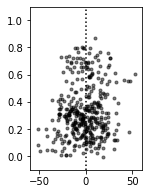

In [51]:
plt.figure(figsize = (2,3))
plt.axvline(color = 'k', linestyle='dotted')
plt.scatter(d_prime_depth[:,2], d_prime_depth[:,0], marker='.', alpha=0.5, color='k')#, color='lightseagreen')
# plt.scatter(d_prime_depth[:,1], d_prime_depth[:,0], marker='.', alpha=0.5, color='peru')


axes = plt.gca()
axes.set_ylim([-.1, 1.1])
axes.set_xlim([-60, 60])

# Figpath = 'Fig_temp/'
# savename = Figpath+"Xz_dsi_pixels_depth_300.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

(-60, 60)

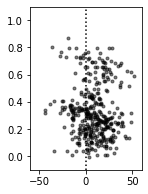

In [52]:
plt.figure(figsize = (2,3))
plt.axvline(color = 'k', linestyle='dotted')
# plt.scatter(d_prime_depth[:,2], d_prime_depth[:,0], marker='.', alpha=0.5, color='lightseagreen')
plt.scatter(d_prime_depth[:,1], d_prime_depth[:,0], marker='.', alpha=0.5,color='k')# color='peru')


axes = plt.gca()
axes.set_ylim([-.1, 1.1])
axes.set_xlim([-60, 60])

# Figpath = 'Fig_temp/'
# savename = Figpath+"Xz_dsi_pixels_depth_150.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')